In [1]:
import pennylane as qml
from pennylane import numpy as npp
from matplotlib import pyplot as plt

# set the random seed
npp.random.seed(42)

# create a device to execute the circuit on
dev = qml.device("default.qubit", wires=4)

@qml.qnode(dev, diff_method="parameter-shift", interface="autograd")
def circuit(params,inputs):
    qml.RY(inputs[0], wires=0)
    qml.RY(inputs[1], wires=1)
    qml.RY(inputs[2], wires=2)
    qml.RY(inputs[3], wires=3)
    

    qml.U3(params[0],params[1],params[2], wires=0)
    qml.U3(params[3],params[4],params[5], wires=1)
    qml.U3(params[6],params[7],params[8], wires=2)
    qml.U3(params[9],params[10],params[11], wires=3)
    

    qml.broadcast(qml.CNOT, wires=[0, 1, 2,3], pattern="ring")
    
    qml.RY(inputs[0]*1.5, wires=0)
    qml.RY(inputs[1]*1.5, wires=1)
    qml.RY(inputs[2]*1.5, wires=2)
    qml.RY(inputs[3]*1.5, wires=3)

    qml.U3(params[12],params[13],params[14], wires=0)
    qml.U3(params[15],params[16],params[17], wires=1)
    qml.U3(params[18],params[19],params[20], wires=2)
    qml.U3(params[21],params[22],params[23], wires=3)

    qml.broadcast(qml.CNOT, wires=[0, 1, 2,3], pattern="ring")
    
    
    qml.RY(inputs[0]*2, wires=0)
    qml.RY(inputs[1]*2, wires=1)
    qml.RY(inputs[2]*2, wires=2)
    qml.RY(inputs[3]*2, wires=3)

    qml.U3(params[24],params[25],params[26], wires=0)
    qml.U3(params[27],params[28],params[29], wires=1)
    qml.U3(params[30],params[31],params[32], wires=2)
    qml.U3(params[33],params[34],params[35], wires=3)

    qml.broadcast(qml.CNOT, wires=[0, 1, 2, 3], pattern="ring")
    
    qml.RY(inputs[0]*2, wires=0)
    qml.RY(inputs[1]*2, wires=1)
    qml.RY(inputs[2]*2, wires=2)
    qml.RY(inputs[3]*2, wires=3)
    
    qml.U3(params[36],params[37],params[38], wires=0)
    qml.U3(params[39],params[40],params[41], wires=1)
    qml.U3(params[42],params[43],params[44], wires=2)
    qml.U3(params[45],params[46],params[47], wires=3)

    qml.broadcast(qml.CNOT, wires=[0, 1, 2, 3], pattern="ring")
    
    #return qml.expval(qml.PauliX(0) @ qml.PauliI(1)@ qml.PauliY(2)@ qml.PauliI(3))
    return qml.expval(qml.PauliX(0) @  qml.PauliY(2))

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split 
import scipy.stats as stats
import math

def norminv(x):
    return ((1.0/math.sqrt(2.0*math.pi)) * math.exp(-x*x*0.5))

def d1(S0, K, r, T, sigma, q):
    deno = (sigma * math.sqrt(T))
    if (deno==0):
        return 0
    logReturns = math.log(S0/float(K)) if ((S0/float(K)) > 0.0) else 0.0
    return (float(logReturns) + (float(r) - float(q) + float(sigma)*float(sigma)*0.5)*float(T)) / float(deno)
    
def d2(S0, K, r, T, sigma, q):
        return d1(S0, K, r, T, sigma, q)-sigma*math.sqrt(T)
        
def bsformula(callput, S0, K, r, T, sigma, q=0):
    N = stats.norm.cdf
                
    def optionValueOfCall(S0, K, r, T, sigma, q):       
        _d1 = d1(S0, K, r, T, sigma, q)
        _d2 = d2(S0, K, r, T, sigma, q)
        return S0*math.exp(-q*T)*N(_d1)- K*math.exp(-r*T)*N(_d2)
      
    def optionValueOfPut(S0, K, r, T, sigma, q):
        _d1 = d1(S0, K, r, T, sigma, q)
        _d2 = d2(S0, K, r, T, sigma, q)
        return float(K)*math.exp(-float(r)*float(T))*N(-_d2) - float(S0)*math.exp(-float(q)*float(T))*N(-_d1)
        
    def delta(callput, S0, K, r, T, sigma, q):
        _d1 = d1(S0, K, r, T, sigma, q)        
        if callput.lower() == "call":            
            return N(_d1) * math.exp(-q*T)
        else:
            return (N(_d1)-1)* math.exp(-q*T)
    
    def vega(S0, K, r, T, sigma, q):
        _d1 = d1(S0, K, r, T, sigma, q)
        return S0  * math.sqrt(T) * norminv(_d1)  * math.exp(-q*T)
    
    if callput.lower()=="call":
        optionValue = optionValueOfCall(S0, K, r, T, sigma, q)
    else:
        optionValue = optionValueOfPut(S0, K, r, T, sigma, q)
        
    _delta = delta(callput, S0, K, r, T, sigma, q)
    _vega = vega(S0, K, r, T, sigma, q)
    
    return (optionValue, _delta, _vega)

def bsm_iv_generator(num_sample = 100,tao_bound=[0.01,2.0],  sigma_bound=[0.01,2.0], 
                     money_bound=[0.3,3.0], rr_bound=[0.01,0.2], callput='call', seed=42):
    
    # input parameters: when callput is not in 'call' or 'put', randomly generate the option price followed by root-finding methods to
    # compute the corresponding implied vol
    # return: X_input = [time,stock,rr, dividen, option_price]. Y_outpu  = volatility 
    np.random.seed(seed)
    tao_min,tao_max = tao_bound[0],tao_bound[1]
    
    sigma_min, sigma_max = sigma_bound[0],sigma_bound[1]
    moneyness_min,moneyness_max = money_bound[0],money_bound[1]
    rr_min,rr_max = rr_bound[0],rr_bound[1]
   
    

    num_sample = int(num_sample)
    xx = np.zeros([num_sample,4],dtype='float')
    
   
    xx[:,0] = np.random.uniform(sigma_min, sigma_max,xx.shape[0])
    xx[:,1] = np.random.uniform(tao_min,tao_max,xx.shape[0])
    xx[:,2] = np.random.uniform(moneyness_min,moneyness_max,xx.shape[0])
    xx[:,3] = np.random.uniform(rr_min,rr_max,xx.shape[0])
   
    
   
    strike=1.0 #fixed strike
    #callput = 'call' # call option
    v = np.zeros(xx.shape[0]) # option value
    k = np.ones(xx.shape[0]) # strike price, just in order to match the shape of v
    
    if callput in ['call','put']:        
        for i in range(0,xx.shape[0]):        
            sigma, T, S0, interest = xx[i,0],xx[i,1],xx[i,2],xx[i,3]
            ## use the Black-Schole function in compfin.py
            v[i] = bsformula(callput, S0, strike, interest, T, sigma)[0]              
            
  
    v= v.reshape(xx.shape[0],1)     
    xx_sample = np.concatenate((xx,v),axis=1) #sigma, time, s, r, v
    
    
    X_input   = xx_sample[:,1:]   # time,stock,rr, option_price
    Y_output  =  xx_sample[:,0] # sigma -implied volatility is the predictive variable.
  
    return X_input,Y_output
#  log-transformation of the option value
def logscale_vol(x_train_dat,y_train_dat,otm_lower=0.0000001):
   # input data: x_train_dat = [time,stock,rr, option_price], y_train_dat = sigma  
   
    xtv_train_log=x_train_dat.copy()    
    ytv_train_log =y_train_dat.copy()
    
    
    #v_lower[v_lower<0.0]=0.0 # V=max(S-E*exp(-rt),0)  
    xintrinsic_train=xtv_train_log[:,1]-1.0*np.exp(-1.0*xtv_train_log[:,2]*xtv_train_log[:,0])
    xintrinsic_train[xintrinsic_train<0.0]=0.0 ## \tilde{V} = max(S-E*exp(-rt),0)
    xtv_train_log[:,-1] = xtv_train_log[:,-1] -xintrinsic_train
    
    ## remove intrisinc values below the threshold (otm_lower \approx machine pricision)  
   
    ytv_train_log = ytv_train_log[~np.less(xtv_train_log[:,-1],otm_lower)]
    xtv_train_log = xtv_train_log[~np.less(xtv_train_log[:,-1],otm_lower),:]
    xtv_train_log[:,-1]=np.log(xtv_train_log[:,-1])

    return xtv_train_log,ytv_train_log 

maturity time  range:
0.5005522117123602 0.5986886936600517
Stock price  range:
0.9802780852212476 1.0188712833088385
interest rate  range:
0.030829391446392806 0.07928252270553005
option value  range:
0.09746900812834913 0.21773104905666268
sigma range:
0.308233797718321 0.6879639408647977
(50, 4)
maturity time  range:
0.5005522117123602 0.5986886936600517
Stock price  range:
0.9802780852212476 1.0188712833088385
interest rate  range:
0.030829391446392806 0.07928252270553005
time option-value  range:
-2.614763769983766 -1.672877716398405
sigma range:
0.308233797718321 0.6879639408647977
(40, 4)
Parameters: [0.64203165 0.08413996 0.16162871 0.89855419 0.60642906 0.00919705
 0.10147154 0.66350177 0.00506158 0.16080805 0.54873379 0.6918952
 0.65196126 0.22426931 0.71217922 0.23724909 0.3253997  0.74649141
 0.6496329  0.84922341 0.65761289 0.5683086  0.09367477 0.3677158
 0.26520237 0.24398964 0.97301055 0.39309772 0.89204656 0.63113863
 0.7948113  0.50263709 0.57690388 0.49251769 0.19524

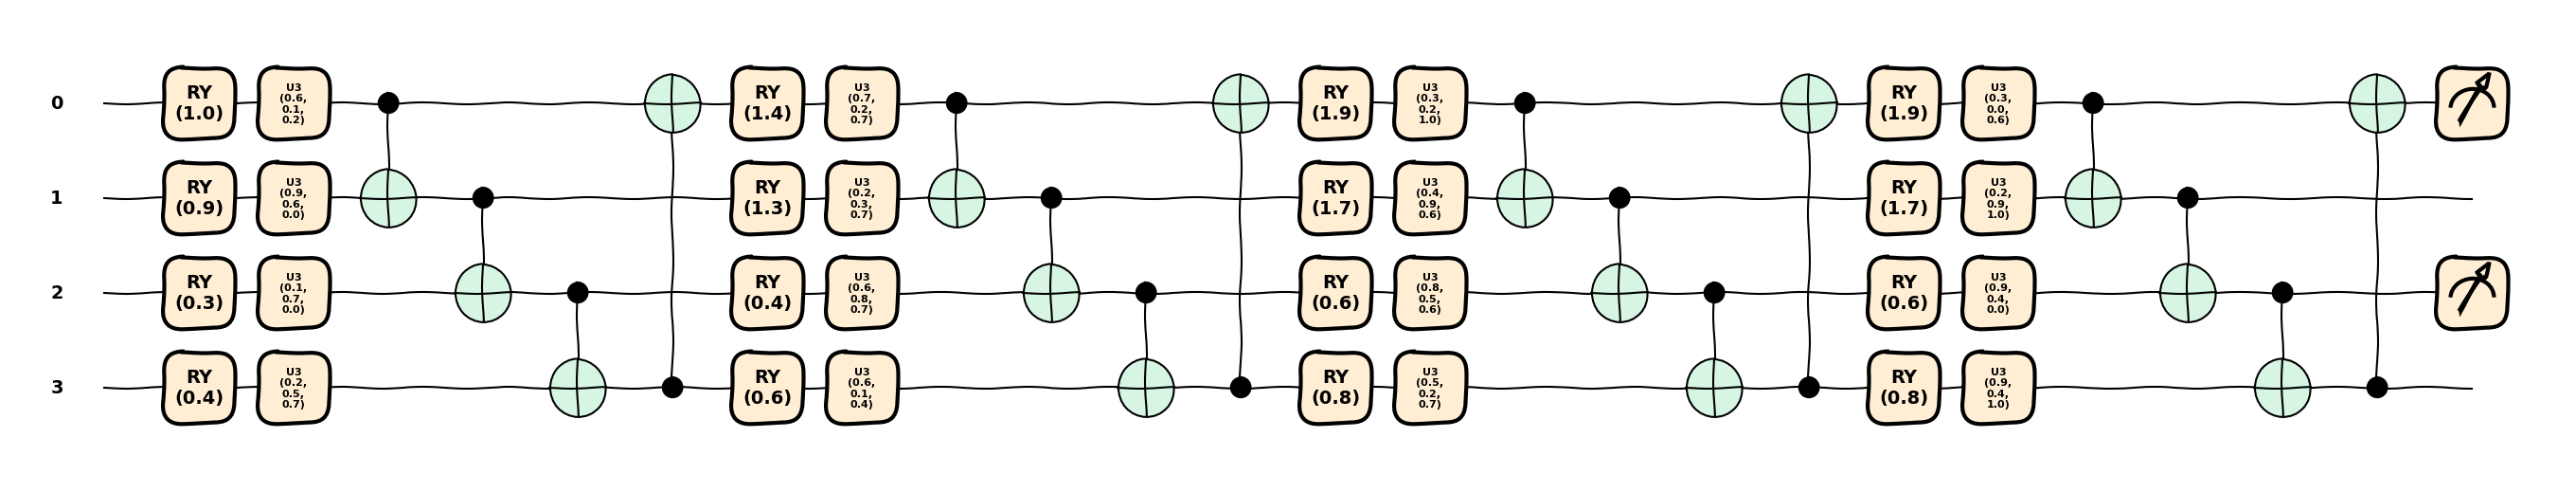

In [3]:
Xin_input,Yin_output=bsm_iv_generator(num_sample = 50,tao_bound=[0.5,0.6],  sigma_bound=[0.3,0.7], 
                                      money_bound=[0.98,1.02], rr_bound=[0.03,0.08],callput='call')

#check the data value range on each dimension
## xin = [maturity time, Stock price, interest rate, dividend, option value]

xlabel =  ['maturity time', 'Stock price', 'interest rate','option value']
for i in range(0, len(xlabel)):
    print(xlabel[i]+'  range:')
    print(np.min(Xin_input[:,i]),np.max(Xin_input[:,i]))
    
print('sigma range:')
print(np.min(Yin_output),np.max(Yin_output))
print(np.shape(Xin_input))

# generate and shuffle the data set into training and test part
xtv_train_log_all,ytv_train_log_all=logscale_vol(Xin_input,Yin_output,otm_lower=1e-4)
'''
for i in range(4):
    xtv_train_log_all[:,i]= min_max_normalization(xtv_train_log_all[:,i])
'''
#ytv_train_log_all=ytv_train_log_all/2
xtv_train_log,xtv_test_log, ytv_train_log, ytv_test_log   = train_test_split(xtv_train_log_all,ytv_train_log_all,test_size=0.2,random_state=42)

xlabel =  ['maturity time', 'Stock price', 'interest rate','time option-value']
for i in range(0, len(xlabel)):
    print(xlabel[i]+'  range:')
    print(np.min(xtv_train_log_all[:,i]),np.max(xtv_train_log_all[:,i]))
    
print('sigma range:')
print(np.min(ytv_train_log),np.max(ytv_train_log))
## how many samples after cleaning
print(np.shape(xtv_train_log))


params = npp.random.random([48], requires_grad=True)
inputs = npp.random.random([4], requires_grad=True)
print("Parameters:", params)
print("inputs:", inputs)
print("Expectation value:", circuit(params,inputs))


qnode = qml.QNode(circuit, dev)
qml.draw_mpl(circuit, decimals=1, style="sketch")(params,inputs)
plt.show()

In [4]:
def parameter_shift_term(qnode,params,inputs, i):
    shifted = params.copy()
    shifted[i] += np.pi/2
    forward = qnode(shifted,inputs)  # forward evaluation

    shifted[i] -= np.pi
    backward = qnode(shifted,inputs) # backward evaluation

    return 0.5 * (forward - backward)

# gradient with respect to the first parameter
print(parameter_shift_term(circuit,params,inputs, 0))


def parameter_shift(qnode, params,inputs):
    gradients = np.zeros([len(params)])

    for i in range(len(params)):
        gradients[i] = parameter_shift_term(qnode,params,inputs, i)

    return gradients

print(parameter_shift(circuit, params,inputs))

grad_function = qml.grad(circuit)
print(grad_function(params,inputs)[0])


print(qml.gradients.param_shift(circuit)(params,inputs)[0])

0.010386585344599686
[ 0.01038659 -0.01998049 -0.01717503  0.23171259  0.00233983  0.00051485
  0.09387403  0.03946221  0.02965953  0.11163172 -0.147724   -0.10834918
  0.18142522  0.22450337  0.1508553   0.13998652  0.18184216  0.17249851
 -0.00795766  0.14447443  0.129738    0.06061232 -0.04138152 -0.00671079
  0.27821558 -0.1538347  -0.20823447 -0.16932058  0.18572619  0.165646
 -0.17727778 -0.20251868 -0.05737549 -0.17897944 -0.17472384 -0.06046138
 -0.00535472 -0.05546237  0.00771827  0.47328385 -0.03823943 -0.09848241
 -0.01200128  0.13119694  0.10452616 -0.078974   -0.13998341 -0.11273409]
[ 0.01038659 -0.01998049 -0.01717503  0.23171259  0.00233983  0.00051485
  0.09387403  0.03946221  0.02965953  0.11163172 -0.147724   -0.10834918
  0.18142522  0.22450337  0.1508553   0.13998652  0.18184216  0.17249851
 -0.00795766  0.14447443  0.129738    0.06061232 -0.04138152 -0.00671079
  0.27821558 -0.1538347  -0.20823447 -0.16932058  0.18572619  0.165646
 -0.17727778 -0.20251868 -0.05737

In [5]:
from sklearn import metrics
from itertools import chain
import time
def QNN(weights, angles):
    return circuit(weights, angles)

def cost(weights, features, labels):
    predictions = [QNN(weights, f) for f in features]
    
    return square_loss(labels, predictions)

def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

def R2(labels, predictions):

    r2 = 0
    for l, p in zip(labels, predictions):
        r2 = r2 + metrics.r2_score(labels, predictions)
    r2 = r2 / len(labels)

    return r2

In [8]:
X=xtv_train_log
Y=ytv_train_log
weights_init = npp.random.random([48], requires_grad=True)
opt = qml.AdamOptimizer(0.01)
batch_size = 20
batches = len (X) // batch_size
X_batches = npp.array_split(npp.arange(len(X)) , batches)


epoch 1
-------------------------------
batch_idx: 0 loss: 0.00038719463486442903 R2: 0.9718269358576258 time: 1704275947.684847
batch_idx: 1 loss: 7.714474550381273e-05 R2: 0.9935096305822768 time: 1704275979.825886
Training [2%] Loss: 0.00023216969018412088 time: 1704275979.825886
weight: [ 0.54411285  0.5194617   0.4988984   0.39367339  0.73338544  0.14119736
  0.36430234  0.24105243 -0.76096545  0.26069938  0.37364081  0.59429204
  0.40629405  0.27041285  0.72687052  0.04862777  0.35848754  0.81122008
  0.93373702  0.84994931  0.78882357  0.14438639  0.14296327  0.58399889
  0.10594647  0.27066493  0.99018216  0.35739302  1.07963748  0.71370242
  0.76146517  0.32655021  0.49877309  0.44791686  0.33097104  0.58669383
  0.6514937   0.1545832   0.74676287  0.02538069  0.87585252  0.91831801
  0.73062462  0.33308871  0.13680595  1.92975135  0.43966995  1.15194067]
epoch 2
-------------------------------
batch_idx: 0 loss: 0.0003089689575836662 R2: 0.9739246829747762 time: 1704276011.90

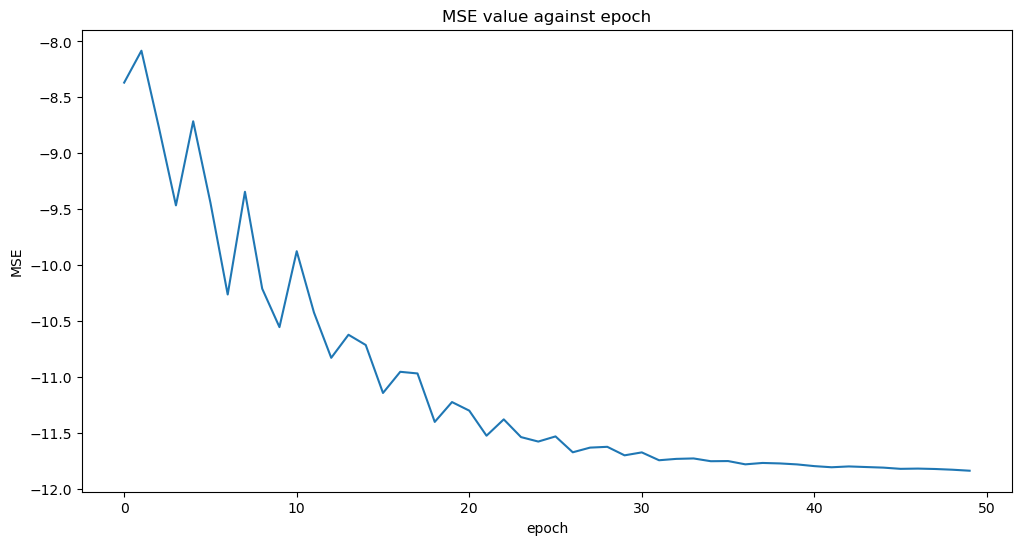

In [9]:

weights =[0.5457064 ,  0.51684106 , 0.49625874,  0.39101955,  0.74559543 , 0.1459648,
  0.36696254,  0.25894846, -0.7580004 ,  0.25798595,  0.39087119,  0.61178083,
  0.42384127,  0.26783496,  0.72425775,  0.05129447 , 0.36118039,  0.81391338,
  0.93639227 , 0.84345717,  0.78550619,  0.14734554 , 0.14558376,  0.58656473,
  0.10858613 , 0.28848394,  1.00872981,  0.35479373 , 1.08242306 , 0.71641846,
  0.75891862,  0.32926841,  0.49615876,  0.43064778 , 0.31366837 , 0.58395333,
  0.66861594, 0.15167445,  0.72917046,  0.02805156 , 0.87322518,  0.91568968,
  0.74873953,  0.33566232,  0.13931622,  1.92704005 , 0.43684662 , 1.14927725]
weights = npp.array(weights, requires_grad=True)

#weights = params
loss_list=[]
r2_list=[]

n_epochs=50

start_time=time.time()
for epoch in range(n_epochs):
    total_loss  = []
    total_r2  = []
    print(f"epoch {epoch+1}\n-------------------------------")
    for it, batch_index in enumerate (chain(*[X_batches])):
        # Update the weights by one optimizer step
        
        X_batch = X[batch_index]
        Y_batch = Y[batch_index]
        weights, _, _ = opt.step(cost, weights, X_batch, Y_batch)

        # Compute accuracy
        predictions = [QNN(weights, x) for x in X]
        r2 = R2(Y, predictions)
        cost_t=cost(weights,X_batch,Y_batch)
        total_loss.append(cost_t)
        total_r2.append(r2)
        end_timet=time.time()
        print("batch_idx:",it,"loss:",cost_t,"R2:",r2,"time:",end_timet)
    loss_list.append(sum(total_loss)/len(total_loss))
    r2_list.append(sum(total_r2)/len(total_r2))
    print('Training [{:.0f}%]'.format(100. * (epoch + 1) / n_epochs),"Loss:", loss_list[-1], "time:",end_timet)
    print("weight:",weights)
    
    
predictions = [QNN(weights, x) for x in X]

train_R2 = R2(Y, predictions)
train_MSE=metrics.mean_squared_error(Y,predictions)
train_RMSE=train_MSE**(1/2)
train_MAE=metrics.mean_absolute_error(Y,predictions)
train_MAPE=metrics.mean_absolute_percentage_error(Y,predictions)

print("train_MSE:",train_MSE)
print("train_RMSE:",train_RMSE)
print("train_MAE:",train_MAE)
print("train_MAPE:",train_MAPE)
print("train_R2:",train_R2)

plt.rcParams["figure.figsize"] = (12, 6)

plt.title("MSE value against epoch")
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.plot(range(len(loss_list)), np.log(loss_list))
plt.show()

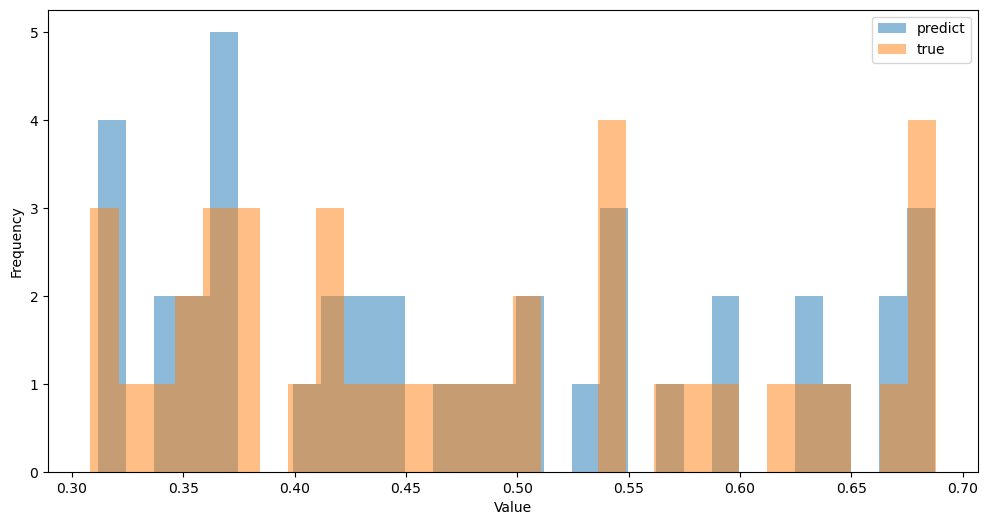

In [10]:
plt.hist(predictions, bins=30, alpha=0.5, label='predict')
plt.hist(Y, bins=30, alpha=0.5, label='true')

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

plt.show()

In [11]:
print(predictions)
print(Y)

[array(0.63026706), array(0.35954511), array(0.34098872), array(0.54281995), array(0.53677108), array(0.32354652), array(0.49878451), array(0.42861259), array(0.51135874), array(0.37425626), array(0.58794063), array(0.42129509), array(0.48248507), array(0.68735829), array(0.36913089), array(0.44617919), array(0.40303942), array(0.50488116), array(0.67332155), array(0.36278528), array(0.32025142), array(0.68392922), array(0.42532257), array(0.68081945), array(0.35500656), array(0.59631616), array(0.66464322), array(0.62771521), array(0.44301029), array(0.34532552), array(0.31363414), array(0.41305888), array(0.47029871), array(0.37375344), array(0.54383245), array(0.6467431), array(0.31173167), array(0.37371642), array(0.53991565), array(0.57295825)]
[0.63297706 0.36240746 0.33906885 0.540446   0.53946339 0.32323344
 0.49807076 0.42468443 0.50802721 0.3733618  0.58322903 0.4216969
 0.48242799 0.68625281 0.36820965 0.44981605 0.40351199 0.50569378
 0.67955421 0.36239781 0.31858017 0.6879

In [12]:
X_test=xtv_test_log
Y_test=ytv_test_log
test_predictions = [QNN(weights, x) for x in X_test]

test_R2 = R2(Y_test, test_predictions)
test_MSE=metrics.mean_squared_error(Y_test,test_predictions)
test_RMSE=test_MSE**(1/2)
test_MAE=metrics.mean_absolute_error(Y_test,test_predictions)
test_MAPE=metrics.mean_absolute_percentage_error(Y_test,test_predictions)

print("train_MSE:",test_MSE)
print("train_RMSE:",test_RMSE)
print("train_MAE:",test_MAE)
print("train_MAPE:",test_MAPE)
print("train_R2:",test_R2)

train_MSE: 1.3892130241300816e-05
train_RMSE: 0.0037272148101901528
train_MAE: 0.0027532046966535716
train_MAPE: 0.0056973304096469965
train_R2: 0.9982178222632692


In [13]:
X1,Y1=bsm_iv_generator(num_sample = 5000,tao_bound=[0.5,0.6],  sigma_bound=[0.3,0.7], 
                                      money_bound=[0.98,1.02], rr_bound=[0.03,0.08],callput='call')
X1,Y1=logscale_vol(X1,Y1,otm_lower=1e-4)

In [14]:

test1_predictions = [QNN(weights, x) for x in X1]

test1_R2 = R2(Y1, test1_predictions)
test1_MSE=metrics.mean_squared_error(Y1,test1_predictions)
test1_RMSE=test1_MSE**(1/2)
test1_MAE=metrics.mean_absolute_error(Y1,test1_predictions)
test1_MAPE=metrics.mean_absolute_percentage_error(Y1,test1_predictions)

print("train_MSE:",test1_MSE)
print("train_RMSE:",test1_RMSE)
print("train_MAE:",test1_MAE)
print("train_MAPE:",test1_MAPE)
print("train_R2:",test1_R2)

train_MSE: 1.5027529206546725e-05
train_RMSE: 0.0038765357223359523
train_MAE: 0.0030237357925453298
train_MAPE: 0.00636456679998671
train_R2: 0.9988801588357921


<function matplotlib.pyplot.show(close=None, block=None)>

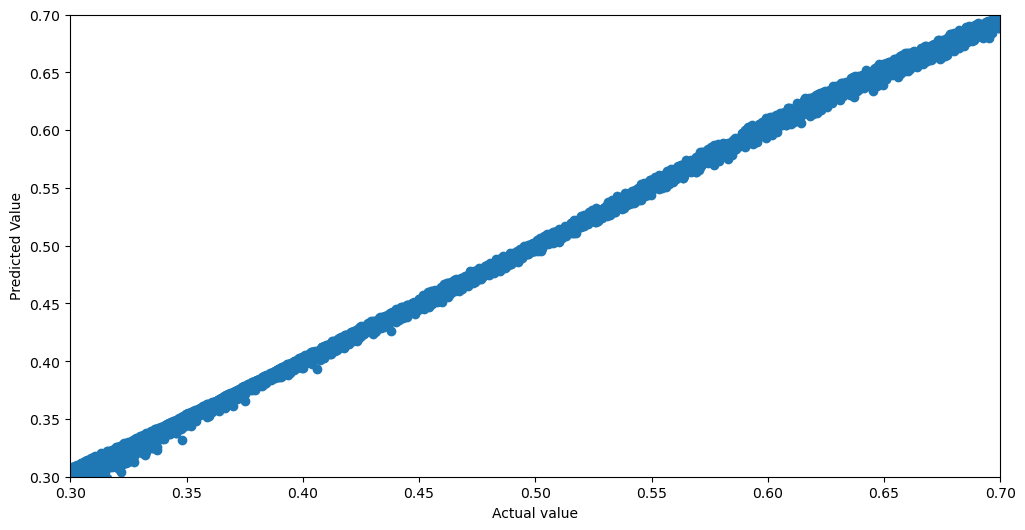

In [17]:
plt.scatter(Y1,test1_predictions)
plt.xlim(0.3,0.7)
plt.ylim(0.3,0.7)
plt.xlabel("Actual value")
plt.ylabel("Predicted Value")
plt.show